In [104]:
import os
import sys
from pathlib import Path

import pandas as pd

print(sys.path.insert(0, os.path.abspath("..")))
from src.config import cfg  # noqa: E402

sys.path.insert(0, os.path.abspath(".."))

None


In [105]:
path = f"{Path().resolve().parent}/{cfg['data']['processed_path']}"
df = pd.read_parquet(path)

print(df.columns.tolist())
df.head()


['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status', 'level', 'itemInSession', 'location', 'userAgent', 'lastName', 'firstName', 'registration', 'gender', 'artist', 'song', 'length', 'ts_dt', 'registration_dt', 'os', 'browser', 'device', 'city', 'region', 'country']


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,song,length,ts_dt,registration_dt,os,browser,device,city,region,country
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,Grand Designs,597.55057,2018-10-01 00:00:11+00:00,2018-07-20 05:11:47+00:00,macOS,Chrome,Desktop,Corpus Christi,TX,USA
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,Bulls,380.21179,2018-10-01 00:00:25+00:00,2018-09-27 17:33:58+00:00,macOS,Chrome,Desktop,Houston-The Woodlands-Sugar Land,TX,USA
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,Because I Got High,202.37016,2018-10-01 00:01:58+00:00,2018-09-03 05:44:15+00:00,macOS,Chrome,Desktop,Orlando-Kissimmee-Sanford,FL,USA
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,<NA>,NaN,2018-10-01 00:01:59+00:00,2018-09-03 05:44:15+00:00,macOS,Chrome,Desktop,Orlando-Kissimmee-Sanford,FL,USA
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,Smile (Radio Edit),194.53342,2018-10-01 00:02:04+00:00,2018-09-02 23:30:18+00:00,Windows,Firefox,Desktop,Mobile,AL,USA


### Date Fields
The date fields: ts timestamp for every log, registration user signup data
so we're using timestamp for log

In [106]:
print('min', df["ts_dt"].min())
print('max', df["ts_dt"].max())

min 2018-10-01 00:00:11+00:00
max 2018-12-01 00:01:06+00:00


<pre lang="markdown">2018-10-01 |---------------------------| 2018-10-31 |--------------------------->| 2018-12-01
<br>            ^ features window (31 days)  ^ cut-off   ^ outcome window (31 days)</pre>

Feature Window: 2018-10-01 ──► 2018-10-31  (cut-off day included)<br>
Target Window:  2018-11-01 ──► 2018-12-01  (31 days future)<br>

Cut-off: 2018-10-31<br>
Inactivity threshold: 31 days<br>
Use ts_dt for all calculations (ignore registration_dt for churn labeling).

In [107]:
path = f"{Path().resolve().parent}/{cfg['data']['labeled_path']}"
df = pd.read_parquet(path)

print(df.columns.tolist())
df.head()


['userId', 'last_ts_dt', 'churn']


,userId,last_ts_dt,churn
0,10,2018-10-09 03:22:44+00:00,1
1,100,2018-11-30 19:34:28+00:00,0
2,100001,2018-10-02 14:50:59+00:00,1
3,100002,2018-11-02 08:17:40+00:00,0
4,100003,2018-11-08 07:19:52+00:00,0


## Data Exploration

In [108]:
CUTT_OFF_DATE = "2018-10-31"

In [109]:
import pandas as pd

processed_path = f"{Path().resolve().parent}/{cfg['data']['processed_path']}"
labeled_path = f"{Path().resolve().parent}/{cfg['data']['labeled_path']}"

processed = pd.read_parquet(processed_path)
labeled = pd.read_parquet(labeled_path)

### A. Demographics & static info

#### Prepare a Customer-Level Table
1. `tenure_days`: the number of days since user registered till the cut-off date


In [110]:
# Get first registration & most common device/region/gender for each user
cust_df = (
    processed.groupby("userId").agg(
        registration_dt=("registration_dt", "first"),       # earliest sign-up
        gender=("gender", "first"),                          # mostly static
        region=("region", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
        device=("device", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
    ).reset_index()
)

# Compute Tenure in days at cutoff
cutoff_date = pd.Timestamp(CUTT_OFF_DATE, tz="UTC")
cust_df["tenure_days"] = (cutoff_date - cust_df["registration_dt"]).dt.days

# Join churn labels
cust_df = cust_df.merge(labeled[["userId","churn"]], on="userId", how="left")
cust_df.head()


,userId,registration_dt,gender,region,device,tenure_days,churn
0,10,2018-09-28 18:31:35+00:00,M,MS,Desktop,32,1
1,100,2018-09-26 17:17:35+00:00,M,TX,Desktop,34,0
2,100001,2018-08-18 21:24:26+00:00,F,FL,Desktop,73,1
3,100002,2018-06-25 13:51:29+00:00,F,CA,Desktop,127,0
4,100003,2018-09-18 22:22:24+00:00,F,FL,Desktop,42,0


#### Explore Gender vs Churn

In [111]:
print(cust_df["gender"].value_counts(dropna=False))
pd.crosstab(cust_df["gender"], cust_df["churn"], normalize="index") * 100

gender
M    250
F    198
Name: count, dtype: int64


churn,0,1
gender,,
F,85.353535,14.646465
M,85.600000,14.400000


#### Explore Region vs Churn

In [112]:
top_regions = cust_df["region"].value_counts().head(10).index
pd.crosstab(cust_df.loc[cust_df["region"].isin(top_regions),"region"],
            cust_df["churn"],
            normalize="index") * 100

churn,0,1
region,,
AZ,90.000000,10.000000
CA,87.096774,12.903226
CT,66.666667,33.333333
FL,84.615385,15.384615
GA,91.666667,8.333333
IN,70.000000,30.000000
MI,81.818182,18.181818
NC,100.000000,0.000000
TX,94.444444,5.555556


#### Explore Device Preference vs Churn

In [113]:
pd.crosstab(cust_df["device"], cust_df["churn"], normalize="index") * 100

churn,0,1
device,,
Desktop,86.223278,13.776722
Mobile,74.074074,25.925926


#### Explore Tenure vs Churn

In [114]:
# Quick numeric bins
cust_df["tenure_bins"] = pd.cut(cust_df["tenure_days"],
                                bins=[0,30,90,180,365,9999],
                                labels=["<1mo","1-3mo","3-6mo","6-12mo",">12mo"])

pd.crosstab(cust_df["tenure_bins"], cust_df["churn"], normalize="index") * 100


churn,0,1
tenure_bins,,
<1mo,80.952381,19.047619
1-3mo,85.838150,14.161850
3-6mo,84.285714,15.714286
6-12mo,87.500000,12.500000


#### Prep: filter to feature window & set snapshot date

In [115]:
from datetime import timedelta

import pandas as pd

cutoff_date = pd.Timestamp(CUTT_OFF_DATE, tz="UTC")

# keep only events up to cutoff
feat_df = processed[processed["ts_dt"] <= cutoff_date].copy()
feat_df["date"] = feat_df["ts_dt"].dt.date     # convenient daily granularity

#### 2. Recency
`recency_days`: number of days between last activity and the cut-off date

In [116]:
recency = (
    feat_df.groupby("userId")["ts_dt"]
           .max()
           .reset_index()
           .rename(columns={"ts_dt": "last_activity"})
)
recency["recency_days"] = (cutoff_date - recency["last_activity"]).dt.days

recency

,userId,last_activity,recency_days
0,10,2018-10-09 03:22:44+00:00,21
1,100,2018-10-27 11:15:12+00:00,3
2,100001,2018-10-02 14:50:59+00:00,28
3,100002,2018-10-30 05:30:08+00:00,0
4,100003,2018-10-28 13:36:03+00:00,2
...,...,...,...
421,95,2018-10-27 19:29:17+00:00,3
422,96,2018-10-30 23:56:38+00:00,0
423,97,2018-10-30 01:53:34+00:00,0
424,98,2018-10-25 20:38:53+00:00,5


### 3. Frequency
`freq`: number of sessions / log events in rolling windows

In [117]:
def count_in_window(days):
    start = cutoff_date - timedelta(days=days)
    mask = feat_df["ts_dt"].between(start, cutoff_date)
    return (
        feat_df.loc[mask]
               .groupby("userId")["sessionId"]
               .nunique()
               .rename(f"freq_{days}d")
    )

freq_7d  = count_in_window(7)
freq_30d = count_in_window(30)
freq_90d = count_in_window(90)

frequency = pd.concat([freq_7d, freq_30d, freq_90d], axis=1).fillna(0).astype(int)
# frequency.loc["10"]

frequency

,freq_7d,freq_30d,freq_90d
userId,,,
100,3,13,13
100002,1,3,3
100003,1,5,5
100007,2,7,7
100008,1,3,3
...,...,...,...
68,0,2,2
71,0,1,1
75,0,3,3


#### 4. Consistency
Compute #events per week → variance / std-dev.<br>
Showing variability of weekly activity

In [118]:
feat_df["week"] = feat_df["ts_dt"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_counts = (
    feat_df.groupby(["userId","week"])["sessionId"]
           .nunique()
           .reset_index()
           .rename(columns={"sessionId":"weekly_sessions"})
)

consistency = (
    weekly_counts.groupby("userId")["weekly_sessions"]
                 .agg(weekly_var="var", weekly_std="std", weekly_mean="mean")
)

consistency

/var/folders/lt/yb6yj7rs5_566mgz0b3c9hd00000gn/T/ipykernel_1172/237692350.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  feat_df["week"] = feat_df["ts_dt"].dt.to_period("W").apply(lambda r: r.start_time)


,weekly_var,weekly_std,weekly_mean
userId,,,
10,NaN,NaN,1.000000
100,2.916667,1.707825,3.250000
100001,NaN,NaN,3.000000
100002,0.000000,0.000000,1.000000
100003,1.333333,1.154701,1.666667
...,...,...,...
95,2.916667,1.707825,3.750000
96,0.500000,0.707107,2.000000
97,3.800000,1.949359,2.400000


#### 5. Trend
slope of recent weekly activity<br>
Compute slope of session counts in the last 2–4 weeks.<br>

Negative slope → declining engagement → higher churn risk.

In [119]:
import numpy as np


def slope_last_weeks(user_df, weeks=4):
    # take only last N weeks
    user_df = user_df.tail(weeks)
    if len(user_df) < 2:
        return 0
    x = np.arange(len(user_df))
    y = user_df["weekly_sessions"].values
    # linear regression slope
    return np.polyfit(x, y, 1)[0]

trend = (
    weekly_counts.groupby("userId")
                 .apply(slope_last_weeks)
                 .rename("activity_slope")
)
trend

/var/folders/lt/yb6yj7rs5_566mgz0b3c9hd00000gn/T/ipykernel_1172/3968430382.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_last_weeks)


userId
10        0.000000e+00
100      -1.000000e-01
100001    0.000000e+00
100002    9.930137e-17
100003    3.972055e-16
              ...     
95        1.300000e+00
96        4.000000e-01
97       -1.300000e+00
98       -1.000000e-01
99        2.000000e-01
Name: activity_slope, Length: 426, dtype: float64

### 6. Session Length
avg / std-dev of session durations

Approximate using `ts_dt` within each `sessionId`

In [120]:
session_stats = (
    feat_df.groupby(["userId","sessionId"])["ts_dt"]
           .agg(["min","max"])
           .reset_index()
)
session_stats["duration_min"] = (session_stats["max"] - session_stats["min"]).dt.total_seconds()/60

session_features = (
    session_stats.groupby("userId")["duration_min"]
                 .agg(avg_session_len="mean", std_session_len="std")
)
session_features

,avg_session_len,std_session_len
userId,,
10,1502.400000,NaN
100,396.888462,358.429493
100001,137.661111,84.399856
100002,89.205556,32.652958
100003,366.583333,527.535892
...,...,...
95,294.848889,197.097528
96,347.940000,404.367186
97,193.693056,178.275461


#### 7. Content Diversity
unique pages and unique songs a user interacted with.

In [121]:
diversity = (
    feat_df.groupby("userId")
           .agg(
               unique_pages=("page","nunique"),
               unique_songs=("song","nunique"),
               unique_artists=("artist","nunique"),
           )
)
diversity

,unique_pages,unique_songs,unique_artists
userId,,,
10,13,350,306
100,15,1175,946
100001,14,96,93
100002,9,64,59
100003,16,447,402
...,...,...,...
95,13,980,773
96,13,781,683
97,13,539,474


#### Combine all engagement features

In [122]:
eng_features = (
    recency
    .set_index("userId")
    .join([freq_7d, freq_30d, freq_90d,
           consistency, trend, session_features, diversity])
    .reset_index()
)

eng_features.head()

,userId,last_activity,recency_days,freq_7d,freq_30d,freq_90d,weekly_var,weekly_std,weekly_mean,activity_slope,avg_session_len,std_session_len,unique_pages,unique_songs,unique_artists
0,10,2018-10-09 03:22:44+00:00,21,NaN,1,1,NaN,NaN,1.000000,0.000000e+00,1502.400000,NaN,13,350,306
1,100,2018-10-27 11:15:12+00:00,3,3.0,13,13,2.916667,1.707825,3.250000,-1.000000e-01,396.888462,358.429493,15,1175,946
2,100001,2018-10-02 14:50:59+00:00,28,NaN,3,3,NaN,NaN,3.000000,0.000000e+00,137.661111,84.399856,14,96,93
3,100002,2018-10-30 05:30:08+00:00,0,1.0,3,3,0.000000,0.000000,1.000000,9.930137e-17,89.205556,32.652958,9,64,59
4,100003,2018-10-28 13:36:03+00:00,2,1.0,5,5,1.333333,1.154701,1.666667,3.972055e-16,366.583333,527.535892,16,447,402


Join churn labels with engagement features

In [123]:
eng = eng_features.merge(labeled[["userId","churn"]], on="userId", how="left")
eng

,userId,last_activity,recency_days,freq_7d,freq_30d,freq_90d,weekly_var,weekly_std,weekly_mean,activity_slope,avg_session_len,std_session_len,unique_pages,unique_songs,unique_artists,churn
0,10,2018-10-09 03:22:44+00:00,21,NaN,1,1,NaN,NaN,1.000000,0.000000e+00,1502.400000,NaN,13,350,306,1
1,100,2018-10-27 11:15:12+00:00,3,3.0,13,13,2.916667,1.707825,3.250000,-1.000000e-01,396.888462,358.429493,15,1175,946,0
2,100001,2018-10-02 14:50:59+00:00,28,NaN,3,3,NaN,NaN,3.000000,0.000000e+00,137.661111,84.399856,14,96,93,1
3,100002,2018-10-30 05:30:08+00:00,0,1.0,3,3,0.000000,0.000000,1.000000,9.930137e-17,89.205556,32.652958,9,64,59,0
4,100003,2018-10-28 13:36:03+00:00,2,1.0,5,5,1.333333,1.154701,1.666667,3.972055e-16,366.583333,527.535892,16,447,402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,95,2018-10-27 19:29:17+00:00,3,5.0,15,15,2.916667,1.707825,3.750000,1.300000e+00,294.848889,197.097528,13,980,773,0
422,96,2018-10-30 23:56:38+00:00,0,5.0,10,10,0.500000,0.707107,2.000000,4.000000e-01,347.940000,404.367186,13,781,683,0
423,97,2018-10-30 01:53:34+00:00,0,2.0,12,12,3.800000,1.949359,2.400000,-1.300000e+00,193.693056,178.275461,13,539,474,0
424,98,2018-10-25 20:38:53+00:00,5,3.0,14,14,0.250000,0.500000,3.750000,-1.000000e-01,384.008333,532.611693,16,1138,917,0


#### Explore Patterns

<Axes: title={'center': 'activity_slope'}, xlabel='churn'>

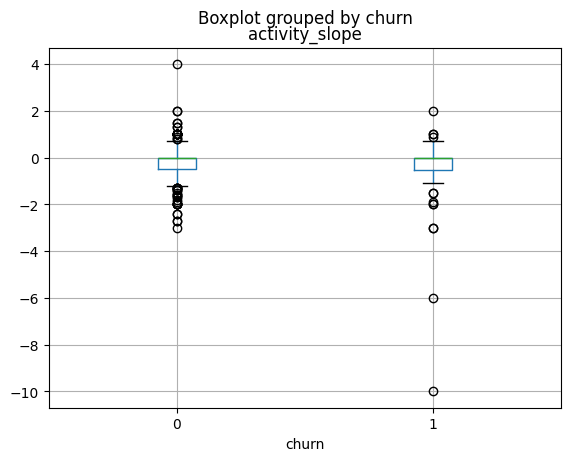

In [124]:
# Recency distribution by churn
eng.groupby("churn")["recency_days"].describe()

# Churn rate vs frequency bins
pd.crosstab(pd.cut(eng["freq_30d"], bins=[0,1,5,10,20,999]),
            eng["churn"], normalize="index") * 100

# Scatter: slope vs churn
eng.boxplot(column="activity_slope", by="churn")
